In [1]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
import os
import moviepy.editor as mp
import librosa
import librosa.display
import IPython.display
from PIL import Image
import tensorflow as tf

Using TensorFlow backend.


# 훈련 데이터 1,2 (이미지, MFCC) 만들기

In [6]:
# 훈련 데이터 1 (ex. 경기 이미지) 만들기

count = 0
videoFile = "20200411_APK_HLE_1.mp4"
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) # = frame rate = 30.0
x=1

while(cap.isOpened()):
    frameId = cap.get(1) # = current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % round(frameRate/2) == 0): # 여기서 frameRate를 2로 나누면 0.5초마다 한 장씩 캡쳐, 2로 안나누면 1초마다.
        filename ="./20200411_APK_HLE_1_image/train_image%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()

print ("Done!")

from PIL import Image

for i in range(len(os.listdir('./20200411_APK_HLE_1_image'))): # 64분짜리 영상을 0.5초마다 캡쳐하면 7680장 나옴
    image = Image.open('./20200411_APK_HLE_1_image/train_image%d.jpg' % i)
    resize_image = image.resize((64,64))
    resize_image.save('./20200411_APK_HLE_1_image_resize/train_image%d.jpg' % i)
    
print ("Done!")

Done!
Done!


In [ ]:
# 훈련 데이터 2 (ex. 소리 이미지(MFCC)) 만들기 - 훈련 데이터 1과 싱크가 같아야 함
# 1번째 이미지는 0~0.5초의 MFCC와 맞고, 2번째 이미지는 0.5~1초의 MFCC와 맞고...

count = 0
videoFile = "20200411_APK_HLE_1.mp4"

i = 0

while True:
    if i < 3842: # 동영상 길이를 초로 변환한 값 넣기 = 3840초, 0.5로 나누면 7680개의 wav 파일 나올 것
        clip = mp.VideoFileClip("20200411_APK_HLE_1.mp4")
        clip = clip.subclip(t_start=(i), t_end=(i+0.5))
        clip.audio.write_audiofile("./20200411_APK_HLE_1_sound/20200411_APK_HLE_1_sound%0.1f.wav" % i)
        i += 0.5
        clip.close()
    else:
        break

In [ ]:
sound_dir = os.listdir('20200411_APK_HLE_1_sound')
        
for i in range(len(sound_dir)):
    y, sr = librosa.load('./20200411_APK_HLE_1_sound/'+sound_dir[i])
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    plt.figure(figsize=(3,3))
    librosa.display.specshow(mfcc, sr=sr)
    fig = plt.gcf()
    fig.savefig('./20200411_APK_HLE_1_mfcc/train_mfcc%d.jpg' % i, transparent=True)
    image = Image.open('./20200411_APK_HLE_1_mfcc/train_mfcc%d.jpg' % i)
    resize_image = image.resize((64,64))
    resize_image.save('./20200411_APK_HLE_1_mfcc_resize/train_mfcc%d.jpg'% i)
    
print ("Done!")

# 데이터 전처리

In [3]:
train_image_data = pd.read_csv('mapping_lol_image.csv')     # reading the csv file
train_image_data.head()      # printing first five rows of the file

,Image_ID,Class
0,train_image0.jpg,0
1,train_image1.jpg,0
2,train_image2.jpg,0
3,train_image3.jpg,0
4,train_image4.jpg,0


In [8]:
train_mfcc_data = pd.read_csv('mapping_lol_mfcc.csv') # train_image와 싱크가 맞아야 하므로 같은 라벨링 된 csv 파일 쓴다
train_mfcc_data.head()

,Image_ID,Class
0,train_mfcc0.jpg,0
1,train_mfcc1.jpg,0
2,train_mfcc2.jpg,0
3,train_mfcc3.jpg,0
4,train_mfcc4.jpg,0


In [4]:
# 이미지 데이터 전처리
# X의 크기가 너무 크면 메모리 에러. (7680, 640, 360, 3)일때 문제 발생함.

X = [ ]     # creating an empty array
for img_name in train_image_data.Image_ID:
    img = plt.imread('' + './20200411_APK_HLE_1_image_resize/'+img_name)
    X.append(img)  # storing each image in array X
X = np.array(X)    # converting list to array

y = train_image_data.Class
dummy_y = np_utils.to_categorical(y)    # one hot encoding Classes

image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(64,64)).astype(int)      # reshaping to 224*224*3
    image.append(a)
X = np.array(image)

from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X, mode='tf')      # preprocessing the input data

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, dummy_y, test_size=0.3, random_state=42)    # preparing the validation set

In [9]:
# mfcc 데이터 전처리
# X의 크기가 너무 크면 메모리 에러. (7680, 640, 360, 3)일때 문제 발생함.

X2 = [ ]
for img_name in train_mfcc_data.Image_ID:
    img = plt.imread('' + './20200411_APK_HLE_1_mfcc_resize/'+img_name)
    X2.append(img) 
X2 = np.array(X2)  

y2 = train_mfcc_data.Class
dummy_y2 = np_utils.to_categorical(y2)    # one hot encoding Classes

image2 = []
for i in range(0,X2.shape[0]):
    a = resize(X2[i], preserve_range=True, output_shape=(64,64)).astype(int)
    image2.append(a)
X2 = np.array(image2)

from keras.applications.vgg16 import preprocess_input
X2 = preprocess_input(X2, mode='tf')      # preprocessing the input data

# validation set을 전체 train set에서 뽑아서 성능이 좋게 나왔을 수도. validation set를 다르게.

from sklearn.model_selection import train_test_split
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X2, dummy_y2, test_size=0.3, random_state=42)    # preparing the validation set

In [10]:
X2.shape

(7680, 64, 64, 3)

In [11]:
X_train2.shape

(5376, 64, 64, 3)

# 모델 훈련

In [12]:
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Input, concatenate

In [14]:
# 이정도를 train, 아예 다른 경기를 val로 할 것

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))    # include_top=False to remove the top layer

X_train2 = base_model.predict(X2)

print(X_train2.shape)

(7680, 2, 2, 512)


# mfcc만 넣어보려고 단순 Sequential 모델 사용해봄

In [13]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))    # include_top=False to remove the top layer

X_train2 = base_model.predict(X_train2)
X_valid2 = base_model.predict(X_valid2)

print(X_train2.shape, X_valid2.shape)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


(5376, 2, 2, 512)


In [9]:
X_train2 = X_train2.reshape(X_train2.shape[0], X_train2.shape[1]*X_train2.shape[2]*X_train2.shape[3]) # converting to 1-D (2304, 2*2*512)
X_valid2 = X_valid2.reshape(X_valid2.shape[0], X_valid2.shape[1]*X_valid2.shape[2]*X_valid2.shape[3])

X_train2 = X_train2/X_train2.max()      # centering the data
X_valid2 = X_valid2/X_train2.max()

In [13]:
# i. Building the model
model = Sequential()
model.add(InputLayer((2*2*512,)))    # input layer
model.add(Dense(units=1024, activation='sigmoid')) # hidden layer
model.add(Dense(2, activation='softmax'))    # output layer

model.summary()

# ii. Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')])

# iii. Training the model
history = model.fit(X_train2, y_train2, epochs=15, validation_data=(X_valid2, y_valid2), verbose=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 2,100,226
Trainable params: 2,100,226
Non-trainable params: 0
_________________________________________________________________
Train on 5376 samples, validate on 2304 samples
Epoch 1/15
 - 11s - loss: 0.3553 - accuracy: 0.8890 - precision: 0.8845 - recall: 0.8845 - val_loss: 0.5211 - val_accuracy: 0.8759 - val_precision: 0.8867 - val_recall: 0.8867
Epoch 2/15
 - 12s - loss: 0.3518 - accuracy: 0.8886 - precision: 0.8870 - recall: 0.8870 - val_loss: 0.7055 - val_accuracy: 0.7682 - val_precision: 0.8772 - val_recall: 0.8772
Epoch 3/15
 - 13s - loss: 0.3516 - accuracy: 0.8882 - precision: 0.8719 - recall: 0.8719 - val_loss: 0.614

In [16]:
test_X2 = []
for img_name in test_mfcc_data.Image_ID:
    img = plt.imread('' + './20200214_DWG_GEN_1_mfcc_resize/'+img_name)
    test_X2.append(img)
    
test_img2 = np.array(test_X2)

test_image2 = []
for i in range(0,test_img2.shape[0]):
    a = resize(test_img2[i], preserve_range=True, output_shape=(64,64)).astype(int)
    test_image2.append(a)
    
test_image2 = np.array(test_image2)

In [17]:
# preprocessing the images
test_image2 = preprocess_input(test_image2, mode='tf')

# extracting features from the images using pretrained model
test_image2 = base_model.predict(test_image2)

# converting the images to 1-D form
test_image2 = test_image2.reshape(test_image2.shape[0], test_image2.shape[1]*test_image2.shape[2]*test_image2.shape[3])

# zero centered images
test_image2= test_image2/test_image2.max()

predictions = model.predict_classes(test_image2)
predictions2 = model.predict(test_image2)

In [18]:
print(predictions.shape)
print(predictions2.shape)

(7680,)
(7680, 2)


mfcc로만 하면 모두 0으로 찍어버림 => 경기 이미지랑 섞었을 때 의미가 있는건가...?

In [19]:
print(list(predictions))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# 이미지랑 mfcc 둘다 사용하기 위해 함수형 API를 쓰는 다중 input 모델 사용

In [11]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))    # include_top=False to remove the top layer

X_train = base_model.predict(X_train)
X_valid = base_model.predict(X_valid)

print(X_train.shape, X_valid.shape)

X_train2 = base_model.predict(X_train2)
X_valid2 = base_model.predict(X_valid2)

print(X_train2.shape, X_valid2.shape)

(5376, 2, 2, 512) (2304, 2, 2, 512)
(5376, 2, 2, 512) (2304, 2, 2, 512)


In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3]) # converting to 1-D (5376, 2*2*512)
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1]*X_valid.shape[2]*X_valid.shape[3])

X_train2 = X_train2.reshape(X_train2.shape[0], X_train2.shape[1]*X_train2.shape[2]*X_train2.shape[3]) # converting to 1-D (2304, 2*2*512)
X_valid2 = X_valid2.reshape(X_valid2.shape[0], X_valid2.shape[1]*X_valid2.shape[2]*X_valid2.shape[3])

X_train = X_train/X_train.max()      # centering the data
X_valid = X_valid/X_train.max()

X_train2 = X_train2/X_train2.max()      # centering the data
X_valid2 = X_valid2/X_train2.max()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 1024)         2098176     input_3[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 1024)         2098176     input_4[0][0]                    
____________________________________________________________________________________________

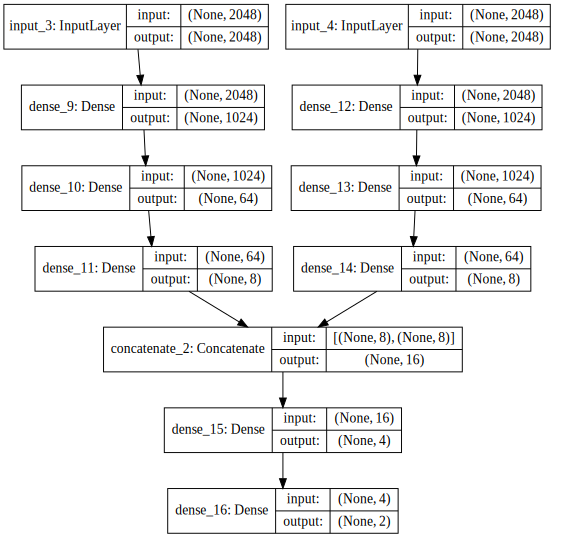

In [8]:
# i. Building the model

# 두 개의 입력층을 정의
inputA = Input(shape=(2*2*512,))
inputB = Input(shape=(2*2*512,))

# 첫번째 입력층으로부터 분기되어 진행되는 인공 신경망을 정의
x = Dense(1024, activation="relu")(inputA)
x = Dense(64, activation="relu")(x)
x = Dense(8, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)

# 두번째 입력층으로부터 분기되어 진행되는 인공 신경망을 정의
y = Dense(1024, activation="relu")(inputB)
y = Dense(64, activation="relu")(y)
y = Dense(8, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)

# 두개의 인공 신경망의 출력을 연결(concatenate)
result = concatenate([x.output, y.output])
# 연결된 값을 입력으로 받는 밀집층을 추가(Dense layer)
z = Dense(4, activation="relu")(result)
# 2개 클래스로 결과를 보여줄 softmax
z = Dense(2, activation="softmax")(z)

# 결과적으로 이 모델은 두 개의 입력층으로부터 분기되어 진행된 후 마지막에는 하나의 출력을 예측하는 모델이 됨.
model = Model(inputs=[x.input, y.input], outputs=z)

model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, dpi=70, show_shapes=True).create(prog='dot', format='svg'))

In [14]:
# ii. Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')])

# iii. Training the model
history = model.fit([X_train,X_train2], y_train, epochs=20, validation_data=([X_valid,X_valid2], y_valid), verbose=2)

Train on 5376 samples, validate on 2304 samples
Epoch 1/20
 - 21s - loss: 0.2435 - accuracy: 0.9057 - precision: 0.8976 - recall: 0.8976 - val_loss: 0.8070 - val_accuracy: 0.9310 - val_precision: 0.9097 - val_recall: 0.9097
Epoch 2/20
 - 21s - loss: 0.1813 - accuracy: 0.9358 - precision: 0.9190 - recall: 0.9190 - val_loss: 1.1302 - val_accuracy: 0.9258 - val_precision: 0.9227 - val_recall: 0.9227
Epoch 3/20
 - 21s - loss: 0.1497 - accuracy: 0.9501 - precision: 0.9274 - recall: 0.9274 - val_loss: 0.6399 - val_accuracy: 0.9497 - val_precision: 0.9310 - val_recall: 0.9310
Epoch 4/20
 - 20s - loss: 0.1359 - accuracy: 0.9533 - precision: 0.9343 - recall: 0.9343 - val_loss: 1.0436 - val_accuracy: 0.9366 - val_precision: 0.9360 - val_recall: 0.9360
Epoch 5/20
 - 20s - loss: 0.1153 - accuracy: 0.9641 - precision: 0.9381 - recall: 0.9381 - val_loss: 1.3465 - val_accuracy: 0.9388 - val_precision: 0.9402 - val_recall: 0.9402
Epoch 6/20
 - 20s - loss: 0.0972 - accuracy: 0.9717 - precision: 0.9421 

[0.2435050213798171, 0.18131050108266727, 0.14968208948682463, 0.1359162167202504, 0.11531101412505709, 0.09717763074773497, 0.09266494018291789, 0.0782956591442815, 0.06746423776106288, 0.05592963763878548, 0.05331256944919005, 0.05282612645948705, 0.043198704343272505, 0.03827896616089025, 0.041162714717280495, 0.04119600524427369, 0.026092876279086512, 0.03112557030321265, 0.025594409606474938, 0.022202640114669304]
[0.905692, 0.9358259, 0.9501488, 0.953311, 0.9640997, 0.9717262, 0.9696801, 0.97693455, 0.9812128, 0.984933, 0.98716515, 0.9858631, 0.9873512, 0.9920015, 0.9890253, 0.98828125, 0.9947917, 0.9910714, 0.9931176, 0.9947917]
[0.8069779999830884, 1.1301629616516746, 0.639939058735965, 1.0436050270335626, 1.3464765754827743, 0.569474705378525, 0.6272455215219013, 0.9426319799903367, 0.37176589838539553, 0.7415917676343164, 0.6277393445941724, 0.7517154377225476, 0.5206418327418052, 1.0886019727266911, 0.4700992887568039, 0.9402683343634837, 2.0754619422659744, 1.35770137069953

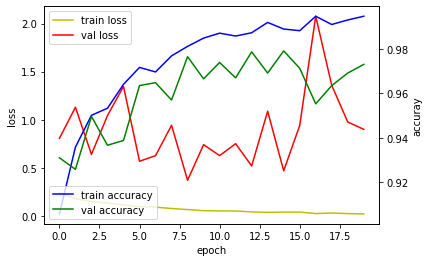

In [16]:
# 학습과정 살펴보기

print(history.history['loss'])
print(history.history['accuracy'])
print(history.history['val_loss'])
print(history.history['val_accuracy'])

%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [17]:
# 모델과 가중치 저장

from keras.models import load_model
model.save('highlight_finder.h5')
model.save_weights('highlight_finder_weight.h5')

# 테스트 데이터 만들기

In [ ]:
# 훈련 데이터 1 (ex. 경기 이미지) 만들기

count = 0
videoFile = "20200214_DWG_GEN_1.mp4"
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) # = frame rate = 30.0
x=1

while(cap.isOpened()):
    frameId = cap.get(1) # = current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % round(frameRate/2) == 0): # 여기서 frameRate를 2로 나누면 0.5초마다 한 장씩 캡쳐, 2로 안나누면 1초마다.
        filename ="./20200214_DWG_GEN_1_image/test_image%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()

print ("Done!")

from PIL import Image

for i in range(len(os.listdir('./20200214_DWG_GEN_1_image'))): # train 동영상보다 길어서 이미지는 7680장 이상 나오는데 7680장으로 그냥 맞춤
    image = Image.open('./20200214_DWG_GEN_1_image/test_image%d.jpg' % i)
    resize_image = image.resize((64,64))
    resize_image.save('./20200214_DWG_GEN_1_image_resize/test_image%d.jpg' % i)
    
print ("Done!")

# 훈련 데이터 2 (ex. 소리 이미지(MFCC)) 만들기 - 훈련 데이터 1과 싱크가 같아야 함
# 1번째 이미지는 0~0.5초의 MFCC와 맞고, 2번째 이미지는 0.5~1초의 MFCC와 맞고...

count = 0
videoFile = "20200214_DWG_GEN_1.mp4"

i = 0

while True:
    if i < 3840: # 동영상 길이를 초로 변환한 값 넣기 = 3840초, 0.5로 나누면 7680개의 wav 파일 나올 것
        clip = mp.VideoFileClip("20200214_DWG_GEN_1.mp4")
        clip = clip.subclip(t_start=(i), t_end=(i+0.5))
        clip.audio.write_audiofile("./20200214_DWG_GEN_1_sound/20200214_DWG_GEN_1_sound%0.1f.wav" % i)
        i += 0.5
        clip.close()
    else:
        break
        
sound_dir = os.listdir('20200214_DWG_GEN_1_sound')
        
for i in range(len(sound_dir)):
    y, sr = librosa.load('./20200214_DWG_GEN_1_sound/'+sound_dir[i])
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    plt.figure(figsize=(3,3))
    librosa.display.specshow(mfcc, sr=sr)
    fig = plt.gcf()
    fig.savefig('./20200214_DWG_GEN_1_mfcc/test_mfcc%d.jpg' % i, transparent=True)
    image = Image.open('./20200214_DWG_GEN_1_mfcc/test_mfcc%d.jpg' % i)
    resize_image = image.resize((64,64))
    resize_image.save('./20200214_DWG_GEN_1_mfcc_resize/test_mfcc%d.jpg'% i)
    
print ("Done!")

# 테스트 데이터 전처리

In [18]:
test_image_data = pd.read_csv('mapping_lol_image_test.csv')
test_image_data.head()

,Image_ID
0,test_image0.jpg
1,test_image1.jpg
2,test_image2.jpg
3,test_image3.jpg
4,test_image4.jpg


In [19]:
test_mfcc_data = pd.read_csv('mapping_lol_mfcc_test.csv')
test_mfcc_data.head()

,Image_ID
0,test_mfcc0.jpg
1,test_mfcc1.jpg
2,test_mfcc2.jpg
3,test_mfcc3.jpg
4,test_mfcc4.jpg


In [20]:
test_X = []
for img_name in test_image_data.Image_ID:
    img = plt.imread('' + './20200214_DWG_GEN_1_image_resize/'+img_name)
    test_X.append(img)
    
test_img = np.array(test_X)

test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(64,64)).astype(int)
    test_image.append(a)
    
test_image = np.array(test_image)

In [21]:
test_X2 = []
for img_name in test_mfcc_data.Image_ID:
    img = plt.imread('' + './20200214_DWG_GEN_1_mfcc_resize/'+img_name)
    test_X2.append(img)
    
test_img2 = np.array(test_X2)

test_image2 = []
for i in range(0,test_img2.shape[0]):
    a = resize(test_img2[i], preserve_range=True, output_shape=(64,64)).astype(int)
    test_image2.append(a)
    
test_image2 = np.array(test_image2)

In [22]:
# preprocessing the images
test_image = preprocess_input(test_image, mode='tf')
test_image2 = preprocess_input(test_image2, mode='tf')

# extracting features from the images using pretrained model
test_image = base_model.predict(test_image)
test_image2 = base_model.predict(test_image2)

# converting the images to 1-D form
test_image = test_image.reshape(test_image.shape[0], test_image.shape[1]*test_image.shape[2]*test_image.shape[3]) # (7680, 2*2*512)
test_image2 = test_image2.reshape(test_image2.shape[0], test_image2.shape[1]*test_image2.shape[2]*test_image2.shape[3])

# zero centered images
test_image = test_image/test_image.max()
test_image2= test_image2/test_image2.max()

# 모델 예측 및 예측값 기록

In [23]:
# make prediction
predictions = model.predict([test_image,test_image2])

In [24]:
predictions.shape

(7680, 2)

In [26]:
# 이렇게 하면 model.predict_class가 하는 기능과 똑같음

class_list = []

for i in range(predictions.shape[0]):
    if predictions[i][0] > 0.5: # 기준 0.5
        class_list.append(0)
    else:
        class_list.append(1)
        
print(class_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [27]:
print(class_list.count(0))
print(class_list.count(1))

7237
443


In [4]:
print("The screen time of non highlight is", class_list.count(0)/2, "seconds")
print("The screen time of highlight is", class_list.count(1)/2, "seconds") # 3분 40초 정도

The screen time of non highlight is 3618.5 seconds
The screen time of highlight is 221.5 seconds


* 대체적으로 드래곤이나 바론 처치 장면은 잘 잡는듯. 매 경기마다, 그리고 한 경기에 몇 번은 있는 장면이라 그런듯.
* 대규모 한타 장면, 포탑 파괴 장면도 몬스터 처치 장면보다는 잘 못잡지만 어느 정도 잡는 편. 위와 비슷한 이유.
* 1대1 싸움이나 마지막 넥서스 부수는 장면은 거의 못잡음. 뜬금없이 1로 표시된 경우가 거의 그런 장면. 
* 1대1 싸움은 경기마다 경우의 수가 다양해서 데이터 부족, 넥서스 부수는 장면은 매 경기마다 있긴 하지만 지속 시간이 상대적으로 짧아 데이터 부족.

1977-1992: 선수들 픽 고르는 장면

3565-3584: 파랑팀이 드래곤 처치 (HL에 포함됨)

3762-3809: 파랑팀이 협곡의 전령을 빼앗음 (HL에 포함됨)

4206-4213: 파랑팀이 드래곤 처치 (HL에 포함됨)

5053-5058: 단순 몬스터 처치

5190-5220: 5대5 한타 (HL에 포함됨)

5256-5272: 4대4 한타 일어나려다가 말음

5300-5335: 빨강팀이 포탑 파괴

5447-5522: 빨강팀이 포탑 파괴, 빨강팀이 드래곤 처치, 5대5 대규모 한타 (HL에 포함됨)

5694-5734: 빨강팀이 바론 처치 직후, 5대5 한타 일어나려다가 말음 (HL에 포함됨) (바론 처치 이전까지 HL 부분이었으면 좋았을 듯, 너무 직후를 HL로 잡음)

6050-6144: 드래곤 생성 후 5대5한타, 빨강팀이 드래곤 처치, (HL에 포함됨) (HL은 아니지만 이후 플레이어 처치 발생)

In [30]:
# 0, 1클래스를 추가해서 새로 csv 파일 만듦

import numpy as np
import pandas as pd

test = pd.read_csv('mapping_lol_image_test.csv') # mapping_lol_image_test.csv를 읽으나 mapping_lol_mfcc_test.csv를 읽으나 상관 없음

test['Class'] = class_list # predictions은 np.array 형태
    
test.to_csv('higlight_test_output.csv', index=False)

**더 해볼것:**

* 20200214_DWG_GEN_1 경기같은 경우엔 하이라이트 파인더가 제대로 기록을 못해 버린 영상. 아무거나 선택했는데 운이 안좋았음.

* => 테스트 결과와 비교하기 위해서 다음 테스트 데이터를 만들땐 제대로 하이라이트가 기록된 영상을 사용하자.


* 공동으로 작업중인 모델도 계속 돌려보되, 개인적으로 이 모델도 계속 개발, 발전시키고자 함. 성능도 괜찮고, 주요 모델과의 비교도 하기 위함.


* 훈련 이미지 10만개정도로 (약 13개) 늘리기, 아예 하이라이트 영상도 추가, 검증 데이터도 다른걸로 하기

* 이미지 크기 255x255로 resize

* 불규칙적인 0과 1처리 (ex. 앞뒤로 연속적인 1과 1 사이에 0이 5개 이하로 있다면 그 0도 1로 만드는 식)

* 1대1 싸움 이미지는 조금 힘들더라도, 마지막 넥서스 부수는 이미지를 더 넣어서 학습시킬 생각.

In [2]:
import pandas as pd
import os

csv = pd.read_csv('mapping_image.csv') # Image_ID와 Class가 두 개의 빈 column으로 존재하는 csv 파일

_list = list(os.listdir('test_image'))

csv['Image_ID'] = _list

csv.to_csv('mapping_image_test.csv', index=False)